In [1]:
import folium
import branca
from folium import plugins
from scipy.interpolate import griddata
import geojsoncontour
import scipy as sp
import scipy.ndimage
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon

In [2]:
# Read the digital elevation  model in longitude, latitude and elevation format.
tricity = pd.read_csv('../data/tricity_travel_03-25-2020_19-41-12.csv')[['stopLon','stopLat','time_sec']]
tricity['time_min'] = round(tricity['time_sec']/60,2)
tricity.head()

,stopLon,stopLat,time_sec,time_min
0,18.63808,54.28478,3444,57.40
1,18.58112,54.30558,2677,44.62
2,18.61525,54.30689,3240,54.00
3,18.91707,54.31122,5932,98.87
4,18.60301,54.31611,2791,46.52


In [3]:
# Read tricity coordinates and create polygon
boundary_google = pd.read_csv("../src/state/tricity_boundary.csv", header=None)
boundary = np.array([[row[1], row[0]]for index, row in boundary_google.iterrows()])
tricity_boundary = Polygon(boundary)

In [123]:
# Setup minimum and maximum values for the contour lines
vmin = tricity['time_min'].min() 
vmax = tricity['time_min'].max()

# Setup colormap
cmap = plt.get_cmap('jet')
colors = [cmap(x) for x in range(0, 240, 2)]

levels = len(colors)
cm = branca.colormap.LinearColormap(colors, vmin=vmin, vmax=vmax).to_step(levels)

# Convertion from dataframe to array
x = np.asarray(tricity.stopLon.tolist())
y = np.asarray(tricity.stopLat.tolist())
z = np.asarray(tricity.time_min.tolist()) 

# Make a grid
x_arr = np.linspace(np.min(x), np.max(x), 500)
y_arr = np.linspace(np.min(y), np.max(y), 500)

x_mesh, y_mesh = np.meshgrid(x_arr, y_arr)

In [124]:
# Grid the time
z_mesh = griddata((x, y), z, (x_mesh, y_mesh), method='linear')
 
# Use Gaussian filter to smoothen the contour
sigma = [3, 3]
z_mesh = sp.ndimage.filters.gaussian_filter(z_mesh, sigma, mode='constant')

In [120]:
# x_mesh_bound = []
# y_mesh_bound = []
# z_mesh_bound = []
# condition = []

# for x_list, y_list, z_list in zip(x_mesh, y_mesh, z_mesh):
#     x_new_list = []
#     y_new_list = []
#     z_new_list = []
#     for x, y, z in zip(x_list, y_list, z_list):
#         point = Point(x,y)
#         c = tricity_boundary.contains(point)
#         condition.append(c)
#         if c is True:
#             x_new_list.append(x)
#             y_new_list.append(y)
#             z_new_list.append(z)
#     x_mesh_bound.append(x_new_list)
#     y_mesh_bound.append(y_new_list)
#     z_mesh_bound.append(z_new_list)

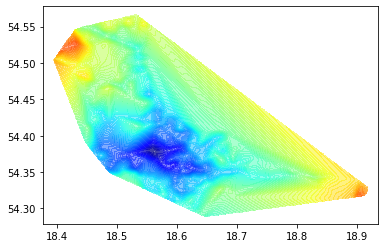

In [125]:
# Create the contour
contourf = plt.contourf(x_mesh,
                        y_mesh,
                        z_mesh,
                        levels,
                        alpha=0.5,
                        colors=colors,
                        linestyles='None',
                        vmin=vmin,
                        vmax=vmax
                       )

In [126]:
# Convert matplotlib contourf to geojson
geojson = geojsoncontour.contourf_to_geojson(
    contourf=contourf,
    min_angle_deg=3.0,
    ndigits=5,
    stroke_width=1,
    fill_opacity=0.1)
 
# Set up the map placeholdder
geomap1 = folium.Map([tricity.stopLat.mean(), tricity.stopLon.mean()], zoom_start=12, tiles="OpenStreetMap")

# Plot the contour on Folium map
folium.GeoJson(
    geojson,
    style_function=lambda x: {
        'color':     x['properties']['stroke'],
        'weight':    x['properties']['stroke-width'],
        'fillColor': x['properties']['fill'],
        'opacity':   1.0,
    }).add_to(geomap1)
 
# Add the colormap to the folium map for legend
cm.caption = 'Time (min)'
geomap1.add_child(cm)
 
# Add the legend to the map
plugins.Fullscreen(position='topright', force_separate_button=True).add_to(geomap1)

geomap1#.save("../data/folium_contour_plot.html")